## Load Libraries

In [175]:
import sys 
import os 
from dotenv import load_dotenv


In [176]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotnine as ggplot 
import unidecode 
import re

In [177]:
from statsforecast import StatsForecast
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pathlib import Path
from datetime import datetime 
import time 

In [178]:
env_path = Path('..') / '.env'


In [179]:
load_dotenv(env_path)

True

In [180]:
TIME_GPT_API_KEY = os.getenv('timegpt_api_key')

In [181]:
from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA,
    SimpleExponentialSmoothing,
    ARIMA,AutoETS, Theta, GARCH, AutoCES
)

## Functions

In [182]:
def clean_columns(df):
    columns = df.columns 
    columns = [x.lower() for x in columns]
    new_columns = []
    for column in columns:
        column = unidecode.unidecode(column)
        column = column.lower()
        column = re.sub(r'[\s\W]+', '_', column)
        column = column.strip('_')
        new_columns.append(column)
    df.columns = new_columns
    return df 



In [183]:
def calculate_days_remaining(future_date_str):
    try:
        target_date = datetime.strptime(future_date_str, '%Y-%m-%d').date()
        current_date = datetime.now().date()
        
        if target_date < current_date:
            return -1  # O puedes lanzar una excepción
        
        return (target_date - current_date).days
    
    except ValueError as e:
        print(f"Error en el formato de fecha: {e}")
        return None


## Analysis

In [184]:
last_date = '2026-01-01'
remaining_days = calculate_days_remaining(last_date)
remaining_days

169

In [185]:
main_path_folder = 'E:/Users/1167486/Local/data/forecasting_data/'

In [186]:
data= pd.read_excel(main_path_folder + 'gold_data/futuros_oro.xlsx')

In [187]:
data = clean_columns(data)

In [188]:
data['fecha'] = pd.to_datetime(data['fecha'])

In [189]:
data['id'] = range(1, len(data)+1)

In [190]:
data['unique_id'] = 'gold_prices'
data = data[['unique_id', 'fecha', 'cierre']]
data.columns = ['unique_id', 'ds', 'y']

In [207]:
maxDate = np.max(data['ds'])

In [208]:
maxDate

Timestamp('2025-07-15 00:00:00')

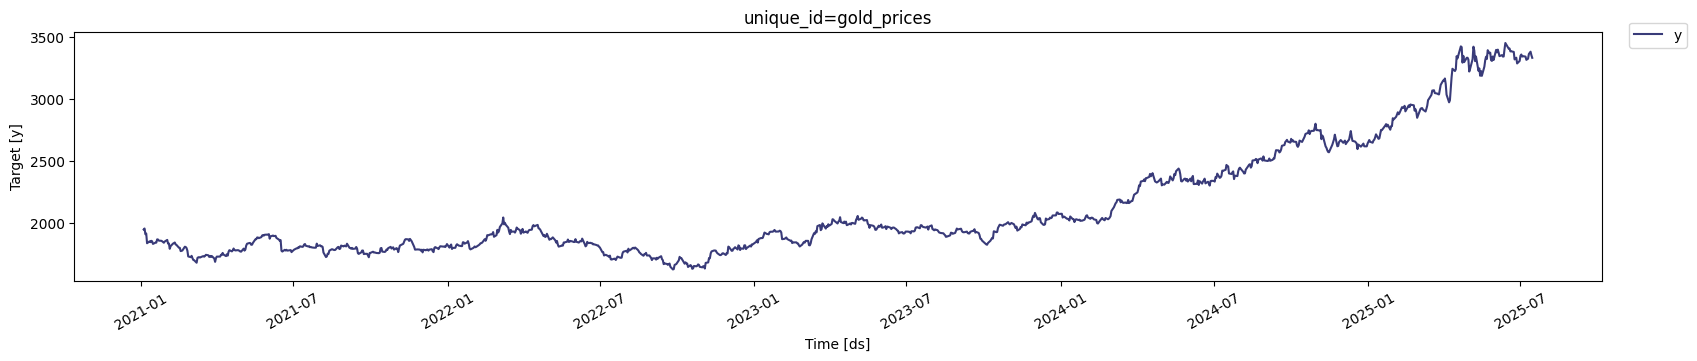

In [191]:
StatsForecast.plot(data)

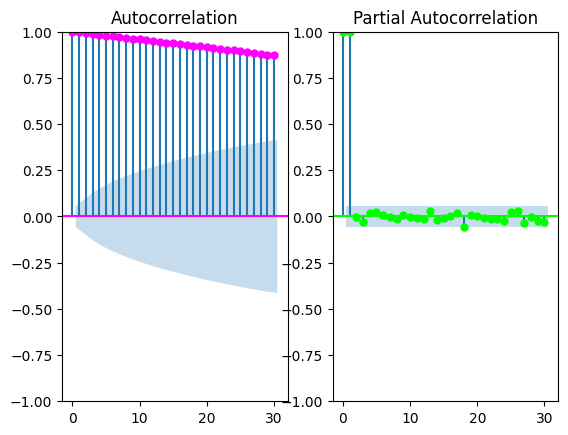

In [192]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(data["y"],  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");


plot_pacf(data["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')
plt.show();

In [193]:
season_length = 5 ### Dias laborales
models = [
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=24),
    HistoricAverage(),
    DOT(season_length=24),
    AutoARIMA(),
    SimpleExponentialSmoothing(alpha=0.5),
    ARIMA(2,1,1),
    AutoCES(season_length=season_length),
    Theta(season_length=season_length)
    ]

In [194]:
# Instantiate StatsForecast class as sf
sf = StatsForecast(
    models=models,
    #freq='1D',
    freq = 'B',
    fallback_model = SeasonalNaive(season_length=7),
    n_jobs=-1,
)

In [195]:
forecasts_df = sf.forecast(df = data, h=remaining_days,
                            level=[90])
forecasts_df.head()

,unique_id,ds,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,CrostonClassic,CrostonClassic-lo-90,CrostonClassic-hi-90,SeasonalNaive,SeasonalNaive-lo-90,...,SES-hi-90,ARIMA,ARIMA-lo-90,ARIMA-hi-90,CES,CES-lo-90,CES-hi-90,Theta,Theta-lo-90,Theta-hi-90
0,gold_prices,2025-07-16,3316.90,3225.356114,3408.443886,3316.90,3225.356114,3408.443886,3452.80,3293.171321,...,3408.443886,3316.90,3225.356114,3408.443886,3342.672058,3290.371155,3395.147949,3336.319478,3302.979436,3378.371541
1,gold_prices,2025-07-17,3321.00,3229.456114,3412.543886,3321.00,3229.456114,3412.543886,3417.30,3257.671321,...,3412.543886,3321.00,3229.456114,3412.543886,3344.225217,3292.221985,3396.886377,3336.693355,3286.779016,3388.431019
2,gold_prices,2025-07-18,3325.70,3234.156114,3417.243886,3325.70,3234.156114,3417.243886,3406.90,3247.271321,...,3417.243886,3325.70,3234.156114,3417.243886,3347.267516,3294.523816,3401.345752,3338.415496,3266.140037,3398.559403
3,gold_prices,2025-07-21,3364.00,3272.456114,3455.543886,3364.00,3272.456114,3455.543886,3408.10,3248.471321,...,3455.543886,3364.00,3272.456114,3455.543886,3348.477487,3295.280835,3401.769702,3339.464681,3267.574800,3401.824813
4,gold_prices,2025-07-22,3382.52,3290.976114,3474.063886,3382.52,3290.976114,3474.063886,3384.97,3225.341321,...,3474.063886,3382.52,3290.976114,3474.063886,3348.550631,3294.701001,3402.216260,3336.637934,3262.137743,3411.644969


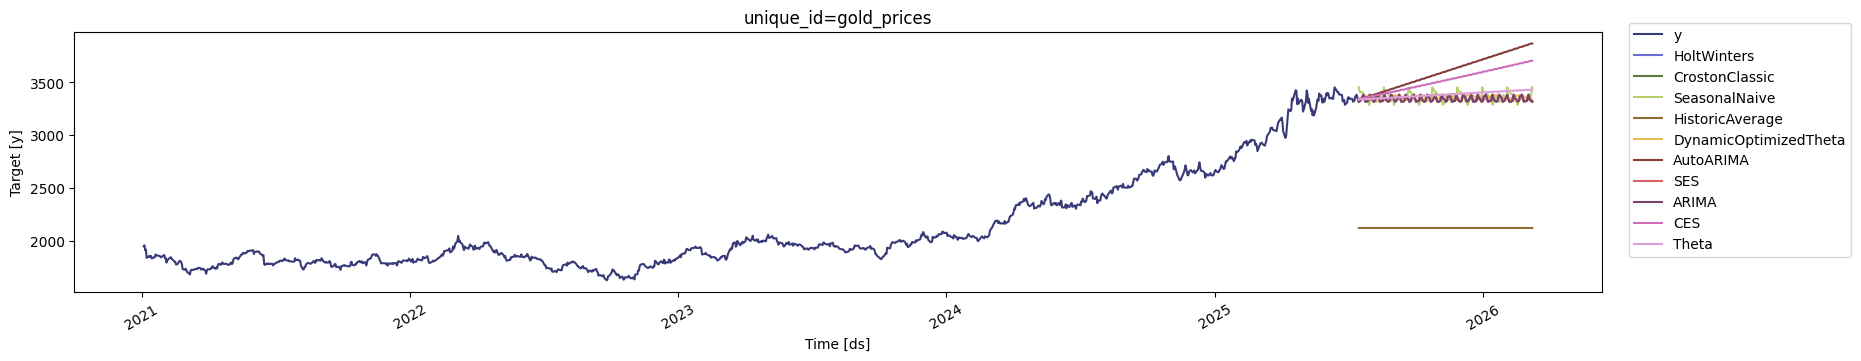

In [196]:
sf.plot(data,forecasts_df)

In [197]:
cv_df = sf.cross_validation(
    df=data,
    h=25,
    step_size=24,
    n_windows=2
)

In [198]:
from utilsforecast.losses import mse

In [199]:
def evaluate_cv(df, metric):
    models = df.columns.drop(['unique_id', 'ds', 'y', 'cutoff']).tolist()
    evals = metric(df, models=models)
    evals['best_model'] = evals[models].idxmin(axis=1)
    return evals

In [200]:
evaluation_df = evaluate_cv(cv_df, mse)
evaluation_df.head()

,unique_id,HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta,AutoARIMA,SES,ARIMA,CES,Theta,best_model
0,gold_prices,4602.60504,3317.069307,13744.297396,1.595365e+06,4156.064081,7550.895359,3019.059536,4602.60504,3866.249204,3102.102786,SES


In [201]:
evaluation_df['best_model'].value_counts().to_frame().reset_index()

,best_model,count
0,SES,1


In [205]:
seasonal_ids = evaluation_df.query('best_model == "SES"')['unique_id']
#sf.plot(data,forecasts_df, unique_ids=seasonal_ids, models=["SES","DynamicOptimizedTheta"])

In [206]:
forecasts_df

,unique_id,ds,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,CrostonClassic,CrostonClassic-lo-90,CrostonClassic-hi-90,SeasonalNaive,SeasonalNaive-lo-90,...,SES-hi-90,ARIMA,ARIMA-lo-90,ARIMA-hi-90,CES,CES-lo-90,CES-hi-90,Theta,Theta-lo-90,Theta-hi-90
0,gold_prices,2025-07-16,3316.90,3225.356114,3408.443886,3316.90,3225.356114,3408.443886,3452.80,3293.171321,...,3408.443886,3316.90,3225.356114,3408.443886,3342.672058,3290.371155,3395.147949,3336.319478,3302.979436,3378.371541
1,gold_prices,2025-07-17,3321.00,3229.456114,3412.543886,3321.00,3229.456114,3412.543886,3417.30,3257.671321,...,3412.543886,3321.00,3229.456114,3412.543886,3344.225217,3292.221985,3396.886377,3336.693355,3286.779016,3388.431019
2,gold_prices,2025-07-18,3325.70,3234.156114,3417.243886,3325.70,3234.156114,3417.243886,3406.90,3247.271321,...,3417.243886,3325.70,3234.156114,3417.243886,3347.267516,3294.523816,3401.345752,3338.415496,3266.140037,3398.559403
3,gold_prices,2025-07-21,3364.00,3272.456114,3455.543886,3364.00,3272.456114,3455.543886,3408.10,3248.471321,...,3455.543886,3364.00,3272.456114,3455.543886,3348.477487,3295.280835,3401.769702,3339.464681,3267.574800,3401.824813
4,gold_prices,2025-07-22,3382.52,3290.976114,3474.063886,3382.52,3290.976114,3474.063886,3384.97,3225.341321,...,3474.063886,3382.52,3290.976114,3474.063886,3348.550631,3294.701001,3402.216260,3336.637934,3262.137743,3411.644969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,gold_prices,2026-03-03,3364.00,2915.528379,3812.471621,3364.00,2915.528379,3812.471621,3364.00,2941.662214,...,3812.471621,3364.00,2915.528379,3812.471621,3693.973035,3637.017859,3750.785864,3426.393219,3025.148292,3853.411156
165,gold_prices,2026-03-04,3382.52,2934.048379,3830.991621,3382.52,2934.048379,3830.991621,3382.52,2960.182214,...,3830.991621,3382.52,2934.048379,3830.991621,3698.624342,3643.380713,3754.860620,3428.933065,3015.629250,3866.441498
166,gold_prices,2026-03-05,3354.05,2905.578379,3802.521621,3354.05,2905.578379,3802.521621,3354.05,2931.712214,...,3802.521621,3354.05,2905.578379,3802.521621,3700.459917,3644.989954,3756.509363,3429.301740,3021.757008,3895.007079
167,gold_prices,2026-03-06,3333.02,2884.548379,3781.491621,3333.02,2884.548379,3781.491621,3333.02,2910.682214,...,3781.491621,3333.02,2884.548379,3781.491621,3703.694962,3647.746924,3761.303943,3431.056095,3021.598093,3887.735356


In [170]:
from nixtla import NixtlaClient

nixtla_api_key = '<your_nixtla_api_key>'

#initiate nixtla client

nixtla_client = NixtlaClient(
   
    api_key = TIME_GPT_API_KEY
)

"""
#rename columns 
df.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)

#define the relevant confidence levels

level = [50,80,90] # confidence levels 

fcst = nixtla_client.forecast(df, h=7, level=level)
fcst.head()

nixtla_client.plot(df, fcst, level=level)
"""

"\n#rename columns \ndf.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)\n\n#define the relevant confidence levels\n\nlevel = [50,80,90] # confidence levels \n\nfcst = nixtla_client.forecast(df, h=7, level=level)\nfcst.head()\n\nnixtla_client.plot(df, fcst, level=level)\n"

In [171]:
data['ds'] = pd.to_datetime(data['ds'])


In [172]:
data = data[['ds', 'y']]

In [173]:
data.groupby('ds')['y'].count().reset_index().sort_values(by='y')

,ds,y
1144,2025-06-13,1
1145,2025-06-16,1
1146,2025-06-17,1
1147,2025-06-18,1
1148,2025-06-19,1
...,...,...
1164,2025-07-11,1
1165,2025-07-13,1
1166,2025-07-14,1
1167,2025-07-15,1


In [ ]:
level = [50,80,90] # confidence levels 

fcst = nixtla_client.forecast(data, h=250, level=level, freq='B')
fcst.head()

nixtla_client.plot(data, fcst, level=level)